In [9]:
!pip uninstall -y jax jaxlib
!pip install -q astroquery kepler.py corner numpyro arviz
!pip install -q git+https://github.com/gaiaverse/scanninglaw.git

Uninstalling jax-0.2.8:
  Successfully uninstalled jax-0.2.8
Uninstalling jaxlib-0.1.59:
  Successfully uninstalled jaxlib-0.1.59


In [10]:
%matplotlib inline

In [11]:
import arviz as az
import pymc3 as pm
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

from astropy.io import fits
from astroquery.gaia import Gaia

import corner
import kepler

import scanninglaw.times as times
from scanninglaw.source import Source

In [12]:
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["font.cursive"] = ["Liberation Sans"]
plt.rcParams["mathtext.fontset"] = "custom"
get_ipython().magic('config InlineBackend.figure_format = "retina"')

## Scanning law

In [13]:
times.fetch()
dr2_sl = times.dr2_sl()

Checking existing file "/usr/local/lib/python3.6/dist-packages/scanninglaw/data/cog/cog_dr2_gaps_and_fractions_v1.h5" to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file "/usr/local/lib/python3.6/dist-packages/scanninglaw/data/cog/cog_dr2_scanning_law_v2.csv" to see if MD5 sum matches ...
File exists. Not overwriting.
Loading auxilliary data ...
t = 31.556 s
  auxilliary:  11.814 s
          sf:   2.303 s
interpolator:  17.439 s


## APOGEE data

First we fetch APW's "Gold Sample" that we want to compare to.
We're going to restrict to sources with measured RV error in Gaia and quite bright.
Then we choose a random target.

In [14]:
with fits.open("https://users.flatironinstitute.org/~apricewhelan/data/dr16-binaries/gold_sample.fits") as f:
    apogee_data = f[1].data

# Bright witth RV error measured
apogee_data = apogee_data[(apogee_data["phot_g_mean_mag"] < 10) & np.isfinite(apogee_data["radial_velocity_error"])]

# Choose a random target

# ind = -6  # Precision similar to Joker
# ind = -3  # Failure
# target = apogee_data[np.argsort(apogee_data["map_P"])[-8]]  # period ~= the baseline

target = apogee_data[14]
target_num_transit = target["rv_nb_transits"]
target_sample_variance = 2 * target_num_transit * (target["radial_velocity_error"] ** 2 - 0.11 ** 2) / np.pi
print("Gaia G-mag =", target["phot_g_mean_mag"])
print("number of transits =", target_num_transit)
print("RV sample standard deviation =", np.sqrt(target_sample_variance))

Gaia G-mag = 9.747034
number of transits = 12
RV sample standard deviation = 12.276306396143415


Let's get the transit times from the Gaia scanning law:

In [15]:
all_transit_times = np.append(*dr2_sl(
    Source(
      target["ra"], target["dec"],
      frame="icrs", unit="deg"
    )
)["times"])
print(len(all_transit_times))

46


## Estimate the per transit RV measurement uncertainty

We're going to estimate the RV error using a model much like Andy's trex mixture model.
First, we select some random targets close to our source in sky position, color, and magnitude:

In [16]:
columns = (
    "source_id", "ra", "dec",
    "parallax", "parallax_error",
    "phot_g_mean_mag", "phot_bp_mean_mag", "phot_rp_mean_mag",
    "bp_rp", "bp_g", "g_rp",
    "radial_velocity", "radial_velocity_error", "rv_nb_transits",
    "random_index", "duplicated_source",
)

query = """
SELECT  TOP 500
        {columns},
        DISTANCE(
            POINT('ICRS', ra, dec),
            POINT('ICRS', {ra}, {dec})
        ) AS dist
FROM    gaiadr2.gaia_source
WHERE   radial_velocity_error IS NOT NULL
AND     duplicated_source = 'false'
AND     rv_nb_transits >= 3
AND     phot_g_mean_mag < {max_mag}
AND     phot_g_mean_mag > {min_mag}
AND     bp_rp < {max_color}
AND     bp_rp > {min_color}
AND     1 = CONTAINS(
          POINT('ICRS', ra, dec),
          CIRCLE('ICRS', {ra}, {dec}, {radius})
        )
ORDER BY
  random_index ASC
""".format(
    columns=", ".join(columns),
    ra=target["ra"],
    dec=target["dec"],
    radius=10.0,
    min_mag=target["phot_g_mean_mag"] - 0.5,
    max_mag=target["phot_g_mean_mag"] + 0.5,
    min_color=target["bp_rp"] - 0.5,
    max_color=target["bp_rp"] + 0.5,
)
job = Gaia.launch_job_async(query)
data = job.get_results()
len(data)

INFO: Query finished. [astroquery.utils.tap.core]


489

Then we fit a model where

$$
X_n = \frac{{s_n}^2\,(T_n - 1)}{{\sigma_n}^2}
$$

is modeled as drawn from a $\chi^2$ with $T_n$ degrees of freedom.
In that equation, ${s_n}^2$ is the sample variance for target $n$ calculated from the RV "error" reported in the catalog, $T_n$ is the number of RV transits, and

$$
{\sigma_n}^2 = {\sigma_0}^2 + {\delta_n}^2
$$

Here, $\sigma_0$ is the per-transit measurement uncertainty shared across the sample and $\delta_n$ is the excess jitter for target $n$, also a parameter.

Do the MCMC:

In [24]:
from jax.config import config

config.update("jax_enable_x64", True)

from jax import random
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO


num_transit = np.array(data["rv_nb_transits"])
sample_variance = 2 * num_transit * (np.array(data["radial_velocity_error"]) ** 2 - 0.11 ** 2) / np.pi

def model(num_transit, sample_variance):
    log_sigma0 = numpyro.sample("log_sigma0", dist.Normal(0.0, 10.0))
    log_dsigma = numpyro.sample("log_dsigma", dist.Normal(0.0, 10.0),
                                    sample_shape=(len(sample_variance),))
    sigma2 = jnp.exp(2 * log_sigma0) + jnp.exp(2 * log_dsigma)
    stat = sample_variance * (num_transit - 1) / sigma2
    numpyro.sample("obs", dist.Chi2(num_transit - 1), obs=stat)

nuts_kernel = NUTS(model, target_accept_prob=0.99)
mcmc = MCMC(nuts_kernel, num_warmup=3000, num_samples=3000, num_chains=2)
rng_key = random.PRNGKey(34923)
mcmc.run(rng_key, num_transit, sample_variance)
inf_data = az.from_numpyro(mcmc)
az.summary(inf_data, ["log_sigma0"])

/usr/local/lib/python3.6/dist-packages/numpyro/infer/mcmc.py:483: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider to use `numpyro.set_host_device_count(2)` at the beginning of your program.
  .format(self.num_chains, xla_bridge.device_count(), self.num_chains))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
log_sigma0,0.047,0.02,0.006,0.083,0.001,0.001,482.0,482.0,482.0,1417.0,1.01


Also do variational inference for comparison:

In [18]:
def guide(num_transit, sample_variance):
    mu_log_sigma0 = numpyro.param("mu_log_sigma0", 0.5 * np.log(np.median(sample_variance)))
    sigma_log_sigma0 = numpyro.param("sigma_log_sigma0", 1.0,
                                     constraint=dist.constraints.positive)
    
    mu_log_dsigma = numpyro.param("mu_log_dsigma", 0.5 * np.log(sample_variance))
    sigma_log_dsigma = numpyro.param("sigma_log_dsigma", np.ones_like(sample_variance),
                                     constraint=dist.constraints.positive)
    
    numpyro.sample("log_sigma0", dist.Normal(mu_log_sigma0, sigma_log_sigma0))
    numpyro.sample("log_dsigma", dist.Normal(mu_log_dsigma, sigma_log_dsigma))

optimizer = numpyro.optim.Adam(step_size=0.05)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 5000, num_transit, sample_variance)
params = svi_result.params

100%|██████████| 5000/5000 [00:09<00:00, 526.87it/s, init loss: 4633.6382, avg. loss [4751-5000]: 2332.5911]


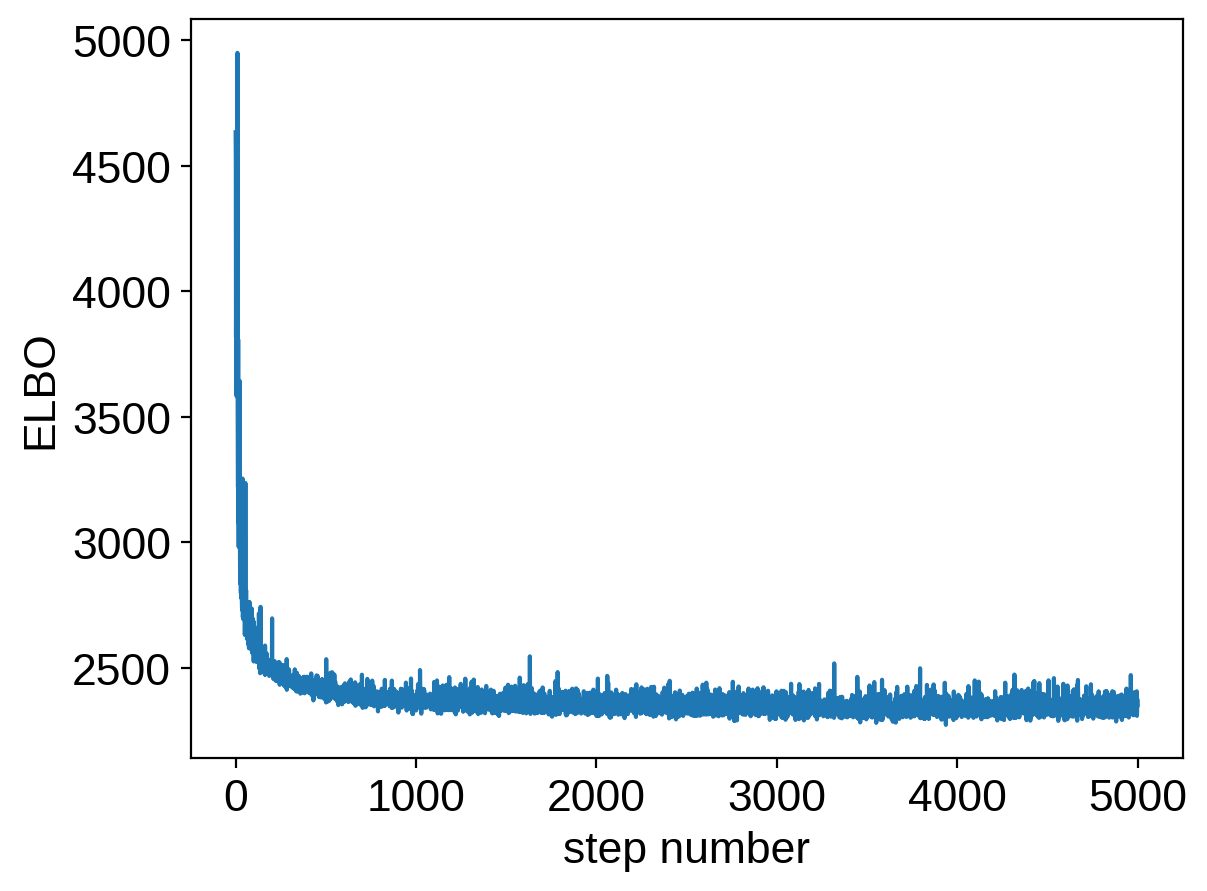

In [19]:
plt.plot(svi_result.losses)
plt.xlabel("step number")
plt.ylabel("ELBO");

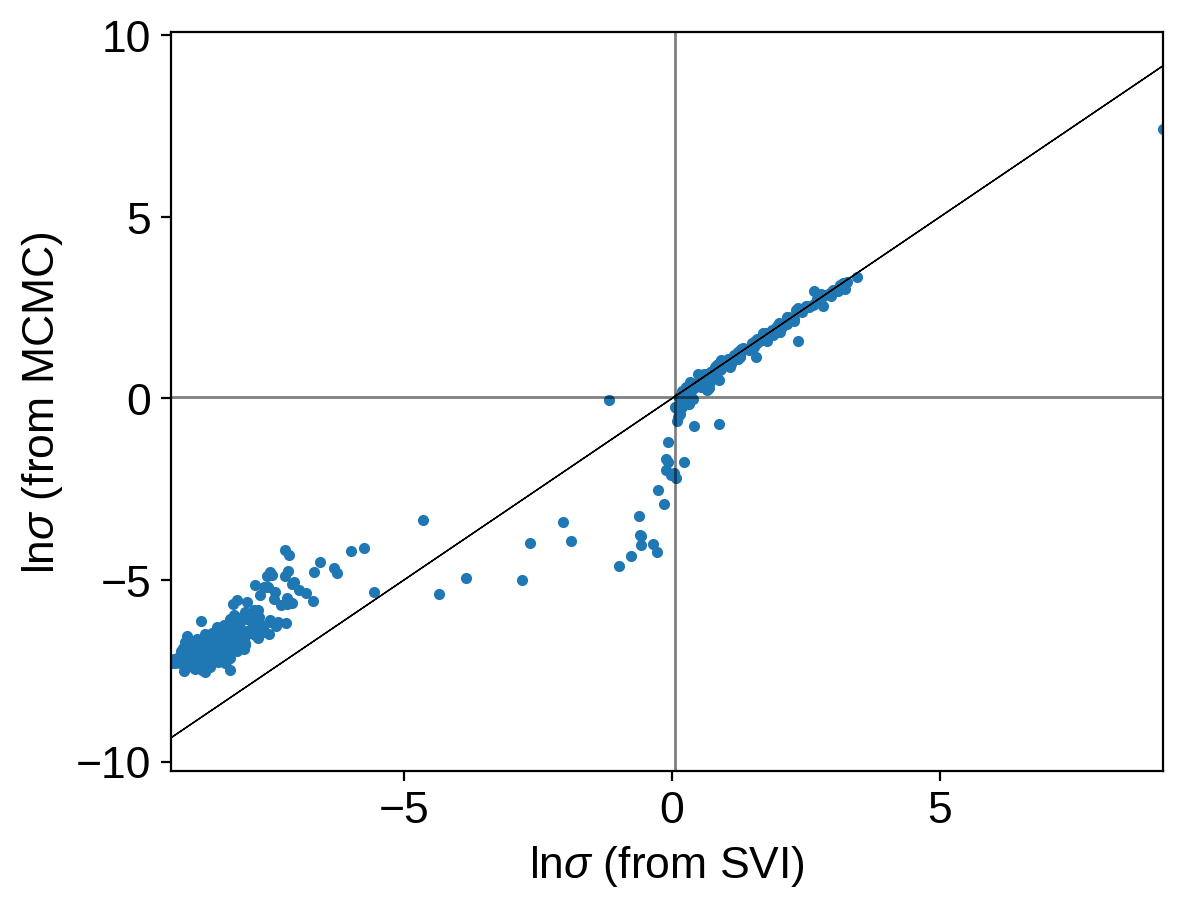

In [20]:
plt.plot(params["mu_log_dsigma"], np.median(inf_data.posterior["log_dsigma"], axis=(0, 1)), ".")
plt.plot(params["mu_log_dsigma"], params["mu_log_dsigma"], "k", lw=0.5)
plt.xlim(params["mu_log_dsigma"].min(), params["mu_log_dsigma"].max())

plt.axhline(np.median(inf_data.posterior["log_sigma0"]), color="k", lw=1, alpha=0.5)
plt.axvline(params["mu_log_sigma0"], color="k", lw=1, alpha=0.5)


plt.xlabel(r"$\ln \sigma$ (from SVI)")
plt.ylabel(r"$\ln \sigma$ (from MCMC)");

And we get an estimate of the per-transit measurement uncertainty.
This relies on the actual measurement uncertainty being the same across the sample and that at least some of the targets have no excess jitter.

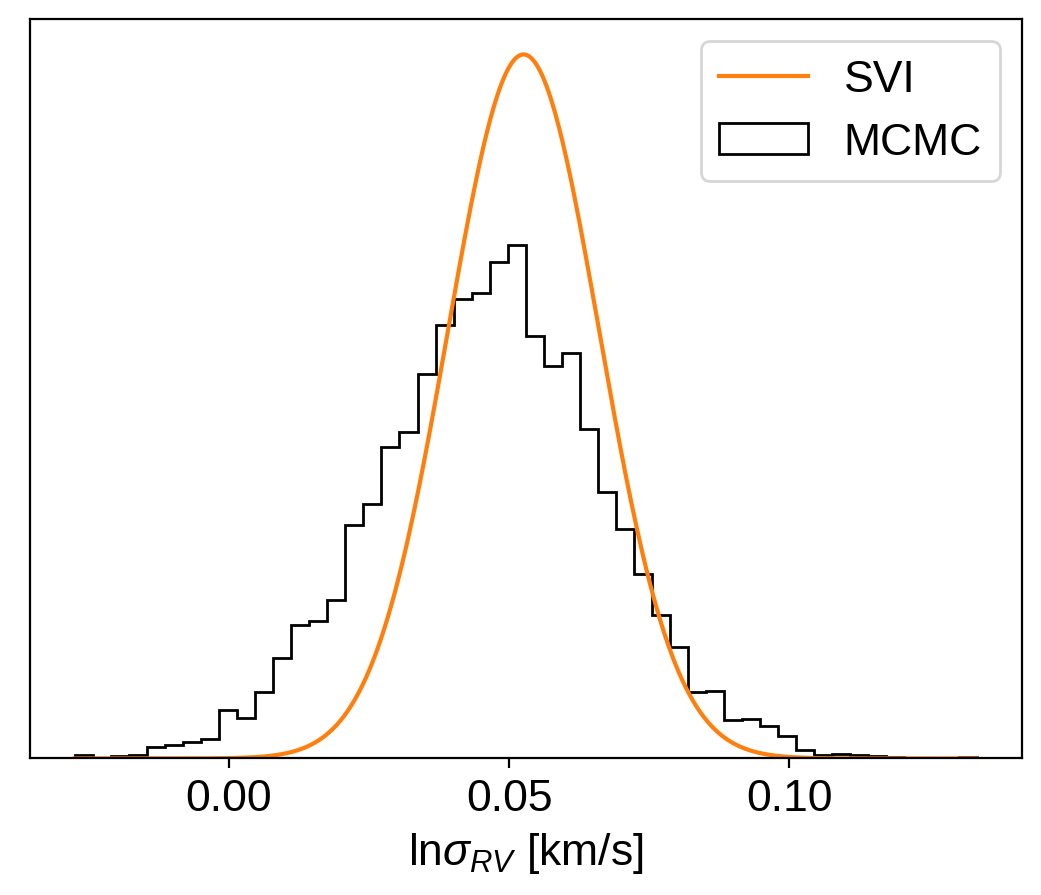

In [21]:
log_sigma = np.array(inf_data.posterior["log_sigma0"]).flatten()
_, bins, _ = plt.hist(log_sigma, 50, histtype="step", density=True, color="k", label="MCMC")

mu, sig = params["mu_log_sigma0"], params["sigma_log_sigma0"]
x = np.linspace(bins.min(), bins.max(), 500)
plt.plot(x, np.exp(-0.5 * (x - mu) ** 2 / sig ** 2) / np.sqrt(2 * np.pi * sig ** 2), "C1", label="SVI")
plt.legend()

log_sigma_prime = mu + sig * np.random.randn(len(log_sigma))

plt.yticks([])
plt.xlabel(r"$\ln \sigma_{RV}$ [km/s]");

## Fit the orbit

Then, finally, we estimate the orbital properties based on the RV error only.
Right now, I'm assuming that we don't know the transit times so our results could probably be improved.
For all the sources I've tried, the error bars on $K$ are big, but it seems to scale correctly when compared to the Joker™ values.

In [22]:
np.random.seed(723)
n_samp = 1000000

# Simulate transit times by sampling target_num_transit samples from the scanning law
t = np.empty((n_samp, target_num_transit))
for n in range(n_samp):
    t[n] = np.random.choice(all_transit_times, size=target_num_transit, replace=False)

# Sample the measurement uncertainty from the trace
sigma = np.exp(np.random.choice(log_sigma, size=n_samp))  

# Sample many parameters from the prior
log_period = np.random.uniform(np.log10(1.0), np.log10(800.0), n_samp)
phase = np.random.uniform(-np.pi, np.pi, n_samp)
log_semiamp = np.random.uniform(np.log(0.1), np.log(100.0), n_samp)
ecc = scipy.stats.beta(0.867, 3.03).rvs(n_samp)
omega = np.random.uniform(-np.pi, np.pi, n_samp)

# Compute the Keplerian model
cosw = np.cos(omega)
sinw = np.sin(omega)
M = 2 * np.pi * t * 10 ** -log_period[:, None] + phase[:, None]
_, cosf, sinf = kepler.kepler(M, ecc[:, None] + np.zeros_like(M))
mod = np.exp(log_semiamp[:, None]) * (cosw[:, None] * (ecc[:, None] + cosf) - sinw[:, None] * sinf)

# Then compute the likelihood for each model
lam = np.sum((mod - np.mean(mod, axis=1)[:, None])**2, axis=1) / sigma ** 2
ncx2 = scipy.stats.ncx2(df=target_num_transit, nc=lam)
log_like = ncx2.logpdf((target_num_transit - 1) * target_sample_variance / sigma ** 2)
log_weight = log_like

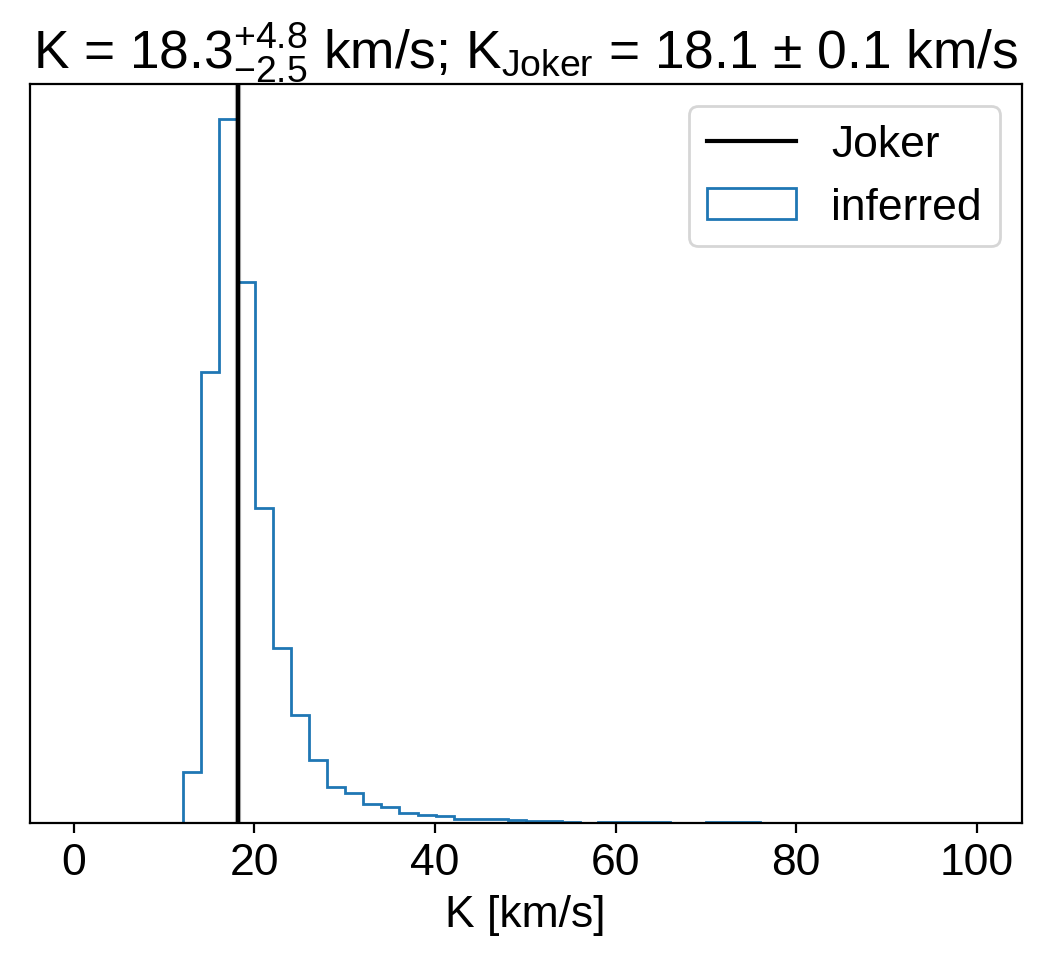

In [23]:
plt.hist(np.exp(log_semiamp), 50, weights=np.exp(log_weight - log_weight.max()), histtype="step", label="inferred")
plt.axvline(target["MAP_K"], color="k", label="Joker")
plt.axvline(target["MAP_K"] - target["MAP_K_err"], color="k", alpha=0.3)
plt.axvline(target["MAP_K"] + target["MAP_K_err"], color="k", alpha=0.3)
plt.yticks([])
plt.xlabel("K [km/s]")

q = corner.quantile(np.exp(log_semiamp), [0.16, 0.5, 0.84], weights=np.exp(log_weight - log_weight.max()))
plt.title(r"K = ${2:.1f}_{{-{3:.1f}}}^{{+{4:.1f}}}$ km/s; K$_\mathrm{{Joker}}$ = {0:.1f} $\pm$ {1:.1f} km/s".format(target["MAP_K"], target["MAP_K_err"], q[1], *np.diff(q)))

plt.legend();